In [1]:
%pylab inline 

import gym
from gym import error, spaces, utils
from gym.utils import seeding
from collections import Counter
import time
import progressbar as pb
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
from empyrical import sortino_ratio, calmar_ratio, omega_ratio

In [3]:
# load the market data
input_source = np.load(open('data_spy.npy','rb'))
to_predict = np.load(open('data_spy_targets.npy','rb'))

In [4]:
input_source.shape, to_predict.shape

((105, 54511), (4, 54511))

In [5]:
to_predict = to_predict[3,:].reshape(-1)

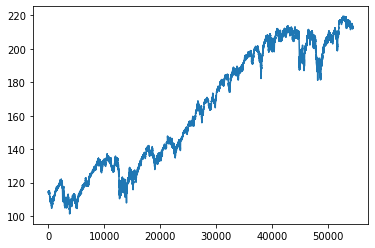

In [6]:
plot(to_predict);

In [7]:
input_source = input_source.T
input_source.shape

(54511, 105)

In [8]:
is_orig = np.copy(input_source)
cp = int(0.8*len(input_source))
test_input_source = input_source[cp:, :]
input_source = input_source[0:cp, :]

In [9]:
input_source.shape, test_input_source.shape

((43608, 105), (10903, 105))

In [10]:
df=pd.DataFrame(input_source)

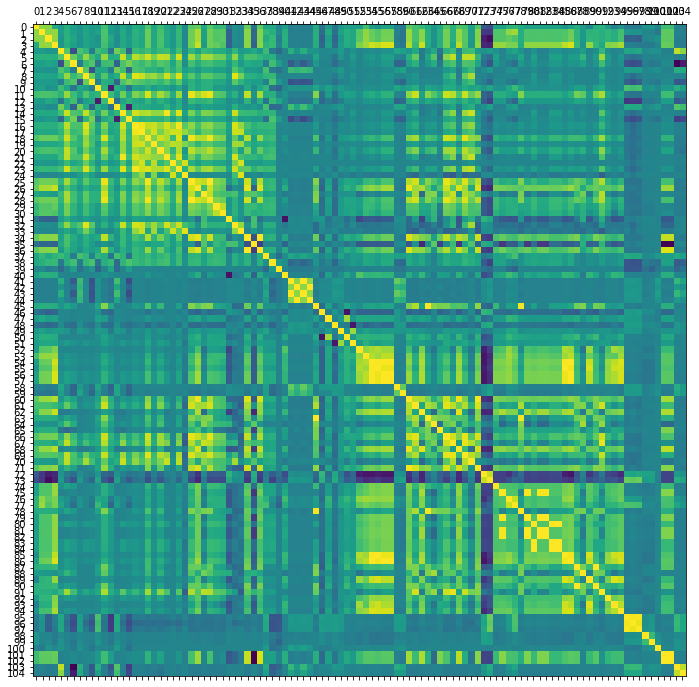

In [11]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

In [12]:
bars_per_episode = 1000
winlen = 1
traded_amt = 1000
commission = 0
slippage = 0

class TradingEnv(gym.Env):
    
    """ This gym implements a simple trading environment for reinforcement learning. """
    
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        self.action_space = spaces.Discrete( 3 )
        self.observation_space= spaces.Box( #np.min(input_source, axis=0), 
                                            #np.max(input_source, axis=0)
                                            np.ones((winlen*input_source.shape[1], ))*-999999, 
                                            np.ones((winlen*input_source.shape[1], ))*999999, 
                                          )
        self.reset()
        
    def _configure(self, display=None):
        self.display = display

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        
        #assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        
        if (self.idx < self.end_idx) and (self.balance > 0):
            self.idx += 1
            done = False
        else:
            done = True
        
        info = {}
        
        observation = input_source[self.idx - winlen : self.idx, :].reshape(-1)
        
        # execute the action and get the reward
        if action == 0 and self.position == 0: # buy 
            self.position = -1
            self.open_idx = self.idx
        if action == 1 and self.position == 0: # sell
            self.position = 1
            self.open_idx = self.idx
        if action == 2:# or ((self.position==0) and ((self.idx - self.open_idx) > 8)): # close
            if self.position == -1: # long
                self.balance += (to_predict[self.idx] - to_predict[self.open_idx])*traded_amt
            elif self.position == 1: # short
                self.balance += (to_predict[self.open_idx] - to_predict[self.idx])*traded_amt
            self.position = 0
        if action == 3:
            pass
        
        self.returns.append(self.balance)
        
        if len(self.returns) > 5:
            reward = sortino_ratio(np.diff(np.array(self.returns[:])))
            #print(np.diff(np.array(self.returns[1:])))
            #print(reward)
            if isnan(reward) or isinf(reward):
                reward = 0
        else:
            reward = 0
        self.prev_balance = self.balance
        
        return observation, reward, done, info
    
    def reset(self):
        # reset and return first observation
        self.idx = np.random.randint(winlen, input_source.shape[0] - bars_per_episode)
        self.end_idx = self.idx + bars_per_episode
        self.position = 0
        self.open_idx = 0
        self.balance = 1000
        self.prev_balance = self.balance
        self.returns = []
        return input_source[self.idx - winlen : self.idx, :].reshape(-1)
    
    def _render(self, mode='human', close=False):
        #... TODO
        pass        


In [13]:
from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy
from stable_baselines.common.vec_env import SubprocVecEnv, VecEnv, VecEnvWrapper
from stable_baselines import A2C, PPO2
from stable_baselines.common.vec_env import DummyVecEnv

# multiprocess environment
#n_cpu = 16
#env = SubprocVecEnv([lambda: TradingEnv() for i in range(n_cpu)])
env = TradingEnv()
env = DummyVecEnv([lambda: env])

model = A2C(MlpLstmPolicy, env, verbose=1, tensorboard_log='/home/peter/tblog')
model.learn(total_timesteps=250000)
model.save("a2c_trading")

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
----------------------------------
| explained_variance | -4.82e+05 |
| fps                | 24        |
| nupdates           | 1         |
| policy_entropy     | 1.1       |
| total_timesteps    | 5         |
| value_loss         | 0.00162   |
----------------------------------
---------------------------------
| explained_variance | 0.000525 |
| fps                | 663      |
| nupdates           | 100      |
| policy_entropy     | 1.1      |
| total_timesteps    | 500      |
| value_loss         | 516      |
---------------------------------
---------------------------------
| explained_variance | 0.0057   |
| fps                | 758      |
| nupdates           | 200      |
| policy_entropy     | 1.1      |
| total_timesteps  

---------------------------------
| explained_variance | -0.0763  |
| fps                | 684      |
| nupdates           | 2700     |
| policy_entropy     | 0.0449   |
| total_timesteps    | 13500    |
| value_loss         | 2.58     |
---------------------------------
---------------------------------
| explained_variance | -0.176   |
| fps                | 684      |
| nupdates           | 2800     |
| policy_entropy     | 0.26     |
| total_timesteps    | 14000    |
| value_loss         | 2.73     |
---------------------------------
---------------------------------
| explained_variance | -0.0231  |
| fps                | 685      |
| nupdates           | 2900     |
| policy_entropy     | 0.0534   |
| total_timesteps    | 14500    |
| value_loss         | 1.84     |
---------------------------------
---------------------------------
| explained_variance | -1.11    |
| fps                | 686      |
| nupdates           | 3000     |
| policy_entropy     | 0.232    |
| total_timest

---------------------------------
| explained_variance | 0.208    |
| fps                | 702      |
| nupdates           | 5800     |
| policy_entropy     | 0.0151   |
| total_timesteps    | 29000    |
| value_loss         | 0.426    |
---------------------------------
---------------------------------
| explained_variance | -0.114   |
| fps                | 703      |
| nupdates           | 5900     |
| policy_entropy     | 0.0114   |
| total_timesteps    | 29500    |
| value_loss         | 11.5     |
---------------------------------
---------------------------------
| explained_variance | -0.112   |
| fps                | 704      |
| nupdates           | 6000     |
| policy_entropy     | 0.132    |
| total_timesteps    | 30000    |
| value_loss         | 62.1     |
---------------------------------
---------------------------------
| explained_variance | 0.256    |
| fps                | 704      |
| nupdates           | 6100     |
| policy_entropy     | 0.00418  |
| total_timest

---------------------------------
| explained_variance | 0.0869   |
| fps                | 713      |
| nupdates           | 8900     |
| policy_entropy     | 0.000333 |
| total_timesteps    | 44500    |
| value_loss         | 7.88     |
---------------------------------
---------------------------------
| explained_variance | 0.0951   |
| fps                | 713      |
| nupdates           | 9000     |
| policy_entropy     | 0.000327 |
| total_timesteps    | 45000    |
| value_loss         | 13.4     |
---------------------------------
---------------------------------
| explained_variance | -0.423   |
| fps                | 713      |
| nupdates           | 9100     |
| policy_entropy     | 0.0511   |
| total_timesteps    | 45500    |
| value_loss         | 1.08     |
---------------------------------
---------------------------------
| explained_variance | -0.0315  |
| fps                | 714      |
| nupdates           | 9200     |
| policy_entropy     | 0.397    |
| total_timest

---------------------------------
| explained_variance | 0.394    |
| fps                | 713      |
| nupdates           | 12000    |
| policy_entropy     | 0.0422   |
| total_timesteps    | 60000    |
| value_loss         | 0.544    |
---------------------------------
---------------------------------
| explained_variance | 0.167    |
| fps                | 713      |
| nupdates           | 12100    |
| policy_entropy     | 0.0255   |
| total_timesteps    | 60500    |
| value_loss         | 11.9     |
---------------------------------
---------------------------------
| explained_variance | -0.238   |
| fps                | 713      |
| nupdates           | 12200    |
| policy_entropy     | 0.256    |
| total_timesteps    | 61000    |
| value_loss         | 0.422    |
---------------------------------
---------------------------------
| explained_variance | -10.1    |
| fps                | 713      |
| nupdates           | 12300    |
| policy_entropy     | 0.701    |
| total_timest

---------------------------------
| explained_variance | -0.421   |
| fps                | 715      |
| nupdates           | 15100    |
| policy_entropy     | 0.209    |
| total_timesteps    | 75500    |
| value_loss         | 7.74     |
---------------------------------
---------------------------------
| explained_variance | -1.88    |
| fps                | 715      |
| nupdates           | 15200    |
| policy_entropy     | 0.349    |
| total_timesteps    | 76000    |
| value_loss         | 31.2     |
---------------------------------
---------------------------------
| explained_variance | -0.0906  |
| fps                | 715      |
| nupdates           | 15300    |
| policy_entropy     | 0.485    |
| total_timesteps    | 76500    |
| value_loss         | 613      |
---------------------------------
---------------------------------
| explained_variance | 0.513    |
| fps                | 715      |
| nupdates           | 15400    |
| policy_entropy     | 0.516    |
| total_timest

---------------------------------
| explained_variance | 0.0654   |
| fps                | 711      |
| nupdates           | 18200    |
| policy_entropy     | 0.339    |
| total_timesteps    | 91000    |
| value_loss         | 61.1     |
---------------------------------
---------------------------------
| explained_variance | -0.0305  |
| fps                | 710      |
| nupdates           | 18300    |
| policy_entropy     | 0.163    |
| total_timesteps    | 91500    |
| value_loss         | 9.48     |
---------------------------------
---------------------------------
| explained_variance | -6.7e-05 |
| fps                | 710      |
| nupdates           | 18400    |
| policy_entropy     | 0.195    |
| total_timesteps    | 92000    |
| value_loss         | 40.6     |
---------------------------------
---------------------------------
| explained_variance | 0.172    |
| fps                | 710      |
| nupdates           | 18500    |
| policy_entropy     | 0.711    |
| total_timest

---------------------------------
| explained_variance | 0.684    |
| fps                | 705      |
| nupdates           | 21300    |
| policy_entropy     | 0.108    |
| total_timesteps    | 106500   |
| value_loss         | 25.1     |
---------------------------------
---------------------------------
| explained_variance | -0.0768  |
| fps                | 705      |
| nupdates           | 21400    |
| policy_entropy     | 0.148    |
| total_timesteps    | 107000   |
| value_loss         | 1.17e+04 |
---------------------------------
---------------------------------
| explained_variance | -6.28    |
| fps                | 704      |
| nupdates           | 21500    |
| policy_entropy     | 0.0913   |
| total_timesteps    | 107500   |
| value_loss         | 74       |
---------------------------------
---------------------------------
| explained_variance | 0.19     |
| fps                | 704      |
| nupdates           | 21600    |
| policy_entropy     | 0.108    |
| total_timest

---------------------------------
| explained_variance | -1.92    |
| fps                | 702      |
| nupdates           | 24400    |
| policy_entropy     | 0.358    |
| total_timesteps    | 122000   |
| value_loss         | 22.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0229   |
| fps                | 702      |
| nupdates           | 24500    |
| policy_entropy     | 0.47     |
| total_timesteps    | 122500   |
| value_loss         | 5.06     |
---------------------------------
---------------------------------
| explained_variance | 0.273    |
| fps                | 701      |
| nupdates           | 24600    |
| policy_entropy     | 0.118    |
| total_timesteps    | 123000   |
| value_loss         | 12.1     |
---------------------------------
---------------------------------
| explained_variance | -0.474   |
| fps                | 701      |
| nupdates           | 24700    |
| policy_entropy     | 0.152    |
| total_timest

---------------------------------
| explained_variance | -2.03    |
| fps                | 697      |
| nupdates           | 27500    |
| policy_entropy     | 0.498    |
| total_timesteps    | 137500   |
| value_loss         | 39.6     |
---------------------------------
---------------------------------
| explained_variance | 0.499    |
| fps                | 697      |
| nupdates           | 27600    |
| policy_entropy     | 0.784    |
| total_timesteps    | 138000   |
| value_loss         | 0.925    |
---------------------------------
---------------------------------
| explained_variance | -0.558   |
| fps                | 697      |
| nupdates           | 27700    |
| policy_entropy     | 0.503    |
| total_timesteps    | 138500   |
| value_loss         | 2.19     |
---------------------------------
---------------------------------
| explained_variance | -0.3     |
| fps                | 697      |
| nupdates           | 27800    |
| policy_entropy     | 0.164    |
| total_timest

---------------------------------
| explained_variance | -0.471   |
| fps                | 697      |
| nupdates           | 30600    |
| policy_entropy     | 0.504    |
| total_timesteps    | 153000   |
| value_loss         | 39.3     |
---------------------------------
---------------------------------
| explained_variance | 0.54     |
| fps                | 697      |
| nupdates           | 30700    |
| policy_entropy     | 0.384    |
| total_timesteps    | 153500   |
| value_loss         | 3.59     |
---------------------------------
---------------------------------
| explained_variance | -0.0348  |
| fps                | 697      |
| nupdates           | 30800    |
| policy_entropy     | 0.682    |
| total_timesteps    | 154000   |
| value_loss         | 128      |
---------------------------------
---------------------------------
| explained_variance | -10.2    |
| fps                | 697      |
| nupdates           | 30900    |
| policy_entropy     | 0.381    |
| total_timest

---------------------------------
| explained_variance | -13.5    |
| fps                | 695      |
| nupdates           | 33700    |
| policy_entropy     | 0.139    |
| total_timesteps    | 168500   |
| value_loss         | 14       |
---------------------------------
---------------------------------
| explained_variance | 0.000924 |
| fps                | 695      |
| nupdates           | 33800    |
| policy_entropy     | 0.166    |
| total_timesteps    | 169000   |
| value_loss         | 3.68e+04 |
---------------------------------
---------------------------------
| explained_variance | -106     |
| fps                | 695      |
| nupdates           | 33900    |
| policy_entropy     | 0.265    |
| total_timesteps    | 169500   |
| value_loss         | 284      |
---------------------------------
---------------------------------
| explained_variance | -3.51    |
| fps                | 695      |
| nupdates           | 34000    |
| policy_entropy     | 0.557    |
| total_timest

---------------------------------
| explained_variance | 0.00851  |
| fps                | 697      |
| nupdates           | 36800    |
| policy_entropy     | 0.000403 |
| total_timesteps    | 184000   |
| value_loss         | 163      |
---------------------------------
---------------------------------
| explained_variance | -0.193   |
| fps                | 697      |
| nupdates           | 36900    |
| policy_entropy     | 0.028    |
| total_timesteps    | 184500   |
| value_loss         | 33.7     |
---------------------------------
---------------------------------
| explained_variance | -0.174   |
| fps                | 697      |
| nupdates           | 37000    |
| policy_entropy     | 0.306    |
| total_timesteps    | 185000   |
| value_loss         | 496      |
---------------------------------
---------------------------------
| explained_variance | -0.204   |
| fps                | 697      |
| nupdates           | 37100    |
| policy_entropy     | 0.00035  |
| total_timest

---------------------------------
| explained_variance | -12.3    |
| fps                | 699      |
| nupdates           | 39900    |
| policy_entropy     | 0.267    |
| total_timesteps    | 199500   |
| value_loss         | 28.2     |
---------------------------------
---------------------------------
| explained_variance | -0.292   |
| fps                | 699      |
| nupdates           | 40000    |
| policy_entropy     | 0.000581 |
| total_timesteps    | 200000   |
| value_loss         | 11.3     |
---------------------------------
---------------------------------
| explained_variance | -0.0405  |
| fps                | 699      |
| nupdates           | 40100    |
| policy_entropy     | 0.000451 |
| total_timesteps    | 200500   |
| value_loss         | 137      |
---------------------------------
---------------------------------
| explained_variance | -1.21    |
| fps                | 699      |
| nupdates           | 40200    |
| policy_entropy     | 0.261    |
| total_timest

---------------------------------
| explained_variance | -7.27    |
| fps                | 700      |
| nupdates           | 43000    |
| policy_entropy     | 0.906    |
| total_timesteps    | 215000   |
| value_loss         | 0.526    |
---------------------------------
---------------------------------
| explained_variance | -3.94    |
| fps                | 700      |
| nupdates           | 43100    |
| policy_entropy     | 0.627    |
| total_timesteps    | 215500   |
| value_loss         | 5.99     |
---------------------------------
---------------------------------
| explained_variance | -15.8    |
| fps                | 700      |
| nupdates           | 43200    |
| policy_entropy     | 0.825    |
| total_timesteps    | 216000   |
| value_loss         | 4.46     |
---------------------------------
---------------------------------
| explained_variance | -31.8    |
| fps                | 701      |
| nupdates           | 43300    |
| policy_entropy     | 0.661    |
| total_timest

---------------------------------
| explained_variance | -13.1    |
| fps                | 702      |
| nupdates           | 46100    |
| policy_entropy     | 0.315    |
| total_timesteps    | 230500   |
| value_loss         | 0.351    |
---------------------------------
---------------------------------
| explained_variance | 0.543    |
| fps                | 702      |
| nupdates           | 46200    |
| policy_entropy     | 0.457    |
| total_timesteps    | 231000   |
| value_loss         | 2.98     |
---------------------------------
---------------------------------
| explained_variance | -0.264   |
| fps                | 702      |
| nupdates           | 46300    |
| policy_entropy     | 0.427    |
| total_timesteps    | 231500   |
| value_loss         | 3.05     |
---------------------------------
---------------------------------
| explained_variance | 0.517    |
| fps                | 702      |
| nupdates           | 46400    |
| policy_entropy     | 0.376    |
| total_timest

---------------------------------
| explained_variance | -6.16    |
| fps                | 703      |
| nupdates           | 49200    |
| policy_entropy     | 0.595    |
| total_timesteps    | 246000   |
| value_loss         | 5.5      |
---------------------------------
---------------------------------
| explained_variance | 0.276    |
| fps                | 703      |
| nupdates           | 49300    |
| policy_entropy     | 0.324    |
| total_timesteps    | 246500   |
| value_loss         | 1.96e+04 |
---------------------------------
---------------------------------
| explained_variance | -27.4    |
| fps                | 703      |
| nupdates           | 49400    |
| policy_entropy     | 0.535    |
| total_timesteps    | 247000   |
| value_loss         | 395      |
---------------------------------
---------------------------------
| explained_variance | -37.7    |
| fps                | 703      |
| nupdates           | 49500    |
| policy_entropy     | 0.234    |
| total_timest

In [14]:
del model # remove to demonstrate saving and loading

model = A2C.load("a2c_trading")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [15]:
input_source = test_input_source 

In [16]:
env = TradingEnv()
env = DummyVecEnv([lambda: env])

100%|██████████| 10000/10000 [00:15<00:00, 653.46it/s]


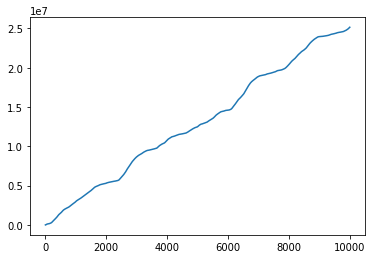

In [27]:

# visualize the behavior for one random episode
bars_per_episode = 10000

states = model.initial_state  # get the initial state vector for the reccurent network
dones = np.zeros(states.shape[0])  # set all environment to not done

observation = env.reset()
env.envs[0].balance = 1000
done = False
navs = []
for i in tqdm(range(bars_per_episode)):
    action, *_ = model.predict(observation, states, dones) 
    observation, reward, done, info = env.step(action)
    navs.append(env.envs[0].balance)

kl = []
t = 0
for n in vstack(navs):
    t = t + n
    kl.append(t)
plot(kl);

In [18]:
# calculate the likelihood of success for any given episode
l = 1000
krl = []
p = pb.ProgressBar(max_value=l)
for i in range(l):
    p.update(i)
    observation = env.reset()
    done = False
    navs = []
    while not done:
        action = model.predict(observation)
        observation, reward, done, info = env.step(action)
        navs.append(env.envs[0].balance)
    krl.append(sum(navs))
p.finish()

 31% (312 of 1000) |######               | Elapsed Time: 0:02:20 ETA:   0:08:37

KeyboardInterrupt: 

In [23]:
krl = array(krl)
print('Profit likelihood: %3.3f%%' % (100*(sum(krl >= 0) / len(krl))))

Profit likelihood: 100.000%


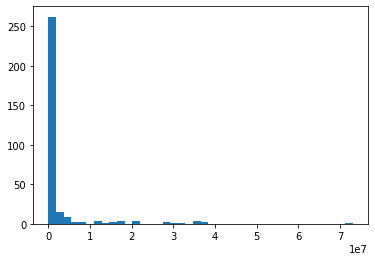

In [24]:
hist(krl, 40);

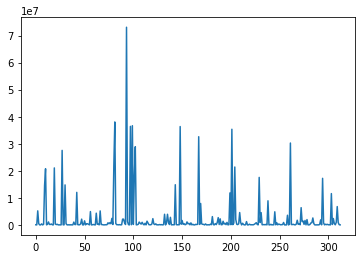

In [25]:
plot(krl);